In [33]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from river.decomposition import OnlineDMDwC, OnlineSVD
from river.feature_extraction import PolynomialExtender
from river.preprocessing import Hankelizer
from tqdm import tqdm

sys.path.append("../")

from functions.chdsubid import (
    SubIDChangeDetector,
    get_default_rank,
    get_default_timedelays,
)
from functions.plot import plot_chd
from functions.preprocessing import hankel
from functions.rolling import Rolling

In [2]:
%load_ext autoreload
%autoreload 2

In [42]:
# Read data
hm = 1
train_data = pd.read_pickle("data/nonlinear-delay-control/train_sim.pkl")
X = pd.DataFrame(train_data["X"][:12000])
U = pd.DataFrame(train_data["U"][:12000])

Y = np.zeros(X.shape[0])

# Introduce gaussian noise
np.random.seed(42)
X += np.random.normal(0, 0.35, X.shape)

# Introduce step reduction in response amplitude
X[3998:4998] += 1.0
Y[3998:4998] = 1

# Introduce step reduction in response amplitude
X[7598:8598] *= 2.0
Y[7598:8598] = 1

# Introduce gradual reduction in responsiveness from 1.0 to 0.25
X[9798:12000] *= np.linspace(1.0, 2.0, X[9798:12000].shape[0])[:, None]
X[12000:] *= 2.0
Y[9798:] = 1

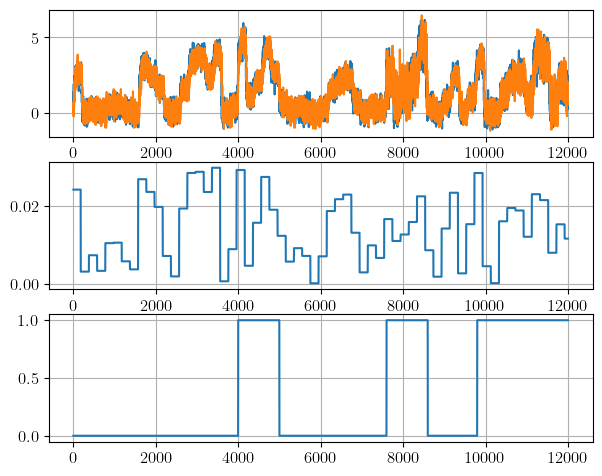

In [43]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(X)
axs[1].plot(U)
axs[2].plot(Y)

In [44]:
window_size: int = 2000
# Base size
ref_size = 200
test_size = 200
# If window_size is not very large, then take half
hm, step = get_default_timedelays(200, 30 // X.shape[1])
hl, step = get_default_timedelays(30, 30 // U.shape[1])
# Optimal low-rank representation of signal with unknown noise variance
p = min(X.shape[1], get_default_rank(hankel(X[:window_size], hm, step)))
print(f"Optimal rank for states is: {p}")
q = min(U.shape[1], get_default_rank(hankel(U[:window_size], hl, step)))
print(f"Optimal rank for inputs is: {q}")

Optimal rank for states is: 2
Optimal rank for inputs is: 1


Snapshots processed: 100%|██████████| 12000/12000 [03:40<00:00, 54.52it/s] 


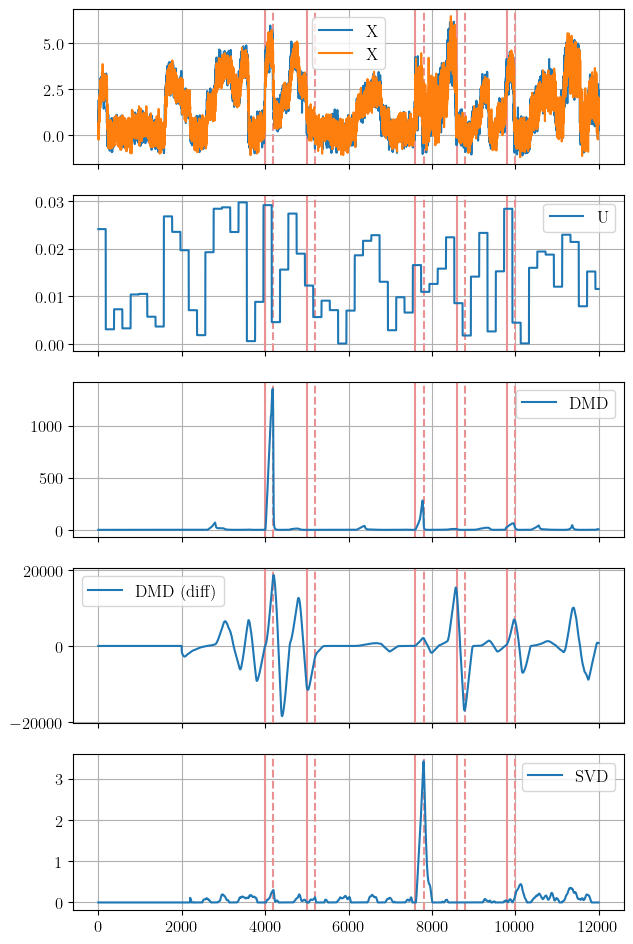

In [64]:
# [donotremove]
# TODO: enable hankelization of us on the fly
U_ = pd.DataFrame(hankel(U, hl, step))

# Initialize Hankelizer
hankelizer = Hankelizer(hm)

# Initialize Transformer
init_size = window_size
odmd = Rolling(
    OnlineDMDwC(
        p=p,
        q=q,
        initialize=init_size - 1,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=None,
    ),
    init_size,
)

# Initialize Change-Point Detector
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size,
    start_soon=True,
    # learn_after_grace=False,
)

# Build pipeline
pipeline_dmd = PolynomialExtender(2) | hankelizer | subid_dmd


osvd = OnlineSVD(p + q, initialize=init_size, force_orth=False)
subid_svd = SubIDChangeDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
pipeline_svd = PolynomialExtender(2) | Hankelizer(hm + hl) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hm * X.shape[1], p), dtype=complex)

# Run pipeline
for i, (x, u) in tqdm(
    enumerate(
        zip(
            X.to_dict(orient="records"),
            U_.to_dict(orient="records"),
        )
    ),
    total=len(X),
    mininterval=1.0,
    desc="Snapshots processed",
):
    scores_dmd[i] = pipeline_dmd.score_one(x)
    scores_svd[i] = pipeline_svd.score_one(x)
    dist[i, :] = subid_dmd.distances
    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

    pipeline_dmd.learn_one(x, **{"u": u})
    x.update(dict([u.popitem()]))
    pipeline_svd.learn_one(x)

# Plot results
fig, axs = plot_chd(
    [X, U, scores_dmd.real, scores_dmd_diff.real, scores_svd.real],
    np.where(np.abs(np.diff(Y, axis=0, prepend=0)) == 1)[0],
    # np.where(Y == 1)[0],
    labels=["X", "U", "DMD", "DMD (diff)", "SVD"],
    grace_period=test_size,
)
fig_name = (
    f"results/.nonlin/nonlin-chd_p{p}_q{q}-l{init_size}_b{ref_size}_t{test_size}"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-hx{hm}-hl{hl}-polyext.pdf"
)
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)